# Colonoscopy polyps detection using small CNN and simple Windows


With a very simple script, it is possible to detect a polyp into a colonoscopy image (this is not the YOLO algorithm!). I will use the previous saved model obtained with simple CNNs.
* Input a colonoscopy image that could contain a polyp
* Load the precalculated model with the small CNN notebook (I used small CNN for simplicity)
* Extract smaller images with shape 150 x 150 x 3 using a sliding window.
* Predict the polyps into these fragments
* Choose the best prediction
* Localize the polyp in the input big picture from colonoscopy.

Let's load the libraries:

In [1]:
import random
import matplotlib.pyplot as plt
import skimage.io
import numpy as np
import os

from keras import *
from keras.models import *
from keras.layers import Input, Dense
from keras.preprocessing import image

from matplotlib.patches import Rectangle

c:\program files\python35\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Define the size of the windows egual with the image shape used as input for the CNN model and the step to slide the search windows. Thus, an input image from colonoscopy will be used to extract smaller fragments of `150 x 150 pixels`:

In [2]:
WINDOW_SIZES = [150]      # using only one size for the sliding window
window_sizes=WINDOW_SIZES 
step=10                   # step of sliding on the input image (how to divide the original image)

Read the colonoscopy image where we trying to find a polyp:

Input image size= 288 384


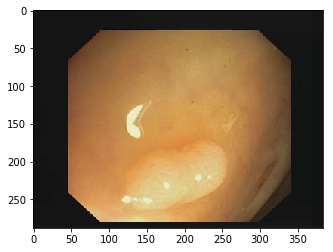

In [3]:
img = skimage.io.imread('results/testImage.tif', plugin='tifffile') # load a test image
print('Input image size=',img.shape[0],img.shape[1])
plt.figure()
plt.imshow(img)
plt.show()

Load a saved model obtaind with small CNN notebook:

In [4]:
model = load_model('saved_models/model_best_Conv-Conv-Conv-FC_full.h5')
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_148 (Conv2D)          (None, 148, 148, 64)      1792      
_________________________________________________________________
activation_270 (Activation)  (None, 148, 148, 64)      0         
_________________________________________________________________
max_pooling2d_148 (MaxPoolin (None, 74, 74, 64)        0         
_________________________________________________________________
conv2d_149 (Conv2D)          (None, 72, 72, 64)        36928     
_________________________________________________________________
activation_271 (Activation)  (None, 72, 72, 64)        0         
_________________________________________________________________
max_pooling2d_149 (MaxPoolin (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_150 (Conv2D)          (None, 34, 34, 128)       73856     
__________

Slide an window on the image to extract fragments 150 x 150 x 3 to make predictions:

In [6]:
max_pred = 0.0 # maximum prediction
max_box = []   # box for the polyp detection

print('--> Searching for a colonoscopy polyp ...')
# Loop window sizes: I will use only 150x150
for win_size in window_sizes:
    # Loop on both dimensions of the image
    for top in range(0, img.shape[0] - win_size + 1, step):
        for left in range(0, img.shape[1] - win_size + 1, step):
            # compute the (top, left, bottom, right) of the bounding box
            box = (top, left, top + win_size, left + win_size)

            # crop the original image
            cropped_img = img[box[0]:box[2], box[1]:box[3],:]
            
            # normalize the cropped image (the same processing used for the CNN dataset)
            cropped_img = cropped_img * 1./255
            # reshape from (150, 150, 3) to (1, 150, 150, 3) for prediction
            cropped_img = cropped_img.reshape((1, cropped_img.shape[0], cropped_img.shape[1], cropped_img.shape[2]))

            # make a prediction for only one cropped small image 
            preds = model.predict(cropped_img, batch_size=None, verbose=0)
            # print(box[0],box[2],box[1],box[3], preds[0][0])
            if preds[0][0]> max_pred:
                max_pred = preds[0][0]
                max_box = box
print('Done!')

--> Searching for a colonoscopy polyp ...
Done!


Show the best prediction box on the original image:

Best prediction: (130, 120, 280, 270) 0.99809307


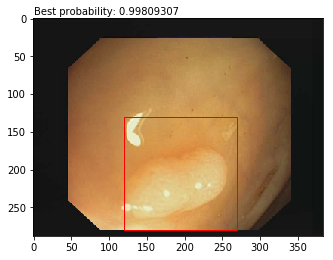

In [18]:
print('Best prediction:', max_box, max_pred)
plt.figure()
plt.imshow(img)
plt.text(1, -5, 'Best probability: '+str(max_pred), fontsize=10)
currentAxis = plt.gca()
currentAxis.add_patch(Rectangle((max_box[1], max_box[0]), 150, 150,linewidth=1,edgecolor='r',facecolor='none'))
plt.show()

## Conclusion

Using a very simple CNN and windows sliding algorithm it is possible to detect a polyp into a colonoscopy image with an accuracy over 90%! You don't know the features of the polyps, the CNN will find them for you! 

Hf with DL! @muntisa

### Acknowledgements

I gratefully acknowledge the support of NVIDIA Corporation with the donation of the Titan Xp GPU used for this research ([https://developer.nvidia.com/academic_gpu_seeding](https://developer.nvidia.com/academic_gpu_seeding)).